In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('C:/Users/admin/Documents/HK5 2025-2026/PTDLKD IS403.Q12/DoAn/Dataset/Xiaomi_clean.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,16.600000,17.000000,16.000000,16.799999,16.799999,462182642
1,2018-07-10,17.000000,19.340000,17.000000,19.000000,19.000000,534072218
2,2018-07-11,18.500000,19.799999,18.299999,19.000000,19.000000,374721138
3,2018-07-12,19.400000,19.700001,19.020000,19.260000,19.260000,132592630
4,2018-07-13,19.600000,21.799999,19.520000,21.450001,21.450001,364065075
...,...,...,...,...,...,...,...
1795,2025-10-22,46.000000,46.740002,45.700001,46.340000,46.340000,121391262
1796,2025-10-23,46.020000,47.080002,45.700001,46.740002,46.740002,106829656
1797,2025-10-24,47.099998,47.400002,45.740002,45.919998,45.919998,170946122
1798,2025-10-27,45.720001,46.000000,43.880001,45.799999,45.799999,282836746


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,16.799999
1,19.000000
2,19.000000
3,19.260000
4,21.450001
5,21.049999
6,20.900000
7,21.549999
8,20.100000
9,19.879999


In [5]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.16312739],
       [0.20559844],
       [0.20559844],
       ...,
       [0.72528952],
       [0.72297293],
       [0.7059845 ]], shape=(1800, 1))

In [6]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.7 * len(data_scaled))
val_size = int(0.1 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

In [7]:
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0
    
    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))
        
    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)

In [8]:
# Grid of time_steps to try
time_step_grid = [30, 50, 60, 70, 100]

In [9]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}

In [10]:
# Defining the GBT Model
gbt = GradientBoostingRegressor(n_iter_no_change=5, tol=0.01, random_state=0)

In [11]:
random_search = RandomizedSearchCV(estimator=gbt, param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=0, n_jobs=-1)

In [12]:
best_val_MAPE = float("inf")
best_params = None
best_time_step = None
best_gbt = None
best_y_pred_val_inv = None
best_y_val_inv = None

In [13]:
for time_step in time_step_grid:
    # Reshape into X=t,t+1,t+2..t+time_step_grid[i] and Y=t+time_step_grid[i]
    X_train, y_train = create_dataset(train_data, time_step)

    # Prepare previous data for validation set
    last_train_data = train_data[-time_step:]

    # Create validation set
    X_val, y_val = create_dataset(val_data, time_step, last_train_data)

    # Fitting the random search model
    random_search.fit(X_train, y_train)

    # Create a new model with these parameters
    candidate_gbt = GradientBoostingRegressor(**random_search.best_params_, random_state=0)

    # Fit the model with the training data
    candidate_gbt.fit(X_train, y_train)

    # Predicting on validation data
    y_pred_val = candidate_gbt.predict(X_val)
    y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))

    valid_MAPE = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)

    # Check if this model is better than the previous ones
    if valid_MAPE < best_val_MAPE:
        best_params = random_search.best_params_
        best_val_MAPE = valid_MAPE
        best_time_step = time_step
        best_gbt = candidate_gbt
        best_y_pred_val_inv = y_pred_val_inv
        best_y_val_inv = y_val_inv

    # Print the MAPE for this time_step
    print(f"Time step: {time_step}, Validation MAPE: {valid_MAPE}")

print("Best time step: ", best_time_step)
print("Best parameters: ", best_params)
print("Validation MAPE with best time step and parameters: ", best_val_MAPE)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 30, Validation MAPE: 0.021927611391227043
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 50, Validation MAPE: 0.023640800199044045
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 60, Validation MAPE: 0.024621775991855412
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 70, Validation MAPE: 0.025022302816031298
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 100, Validation MAPE: 0.023844120307000862
Best time step:  30
Best parameters:  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.15}
Validation MAPE with best time step and parameters:  0.021927611391227043


In [14]:
# Once we have the best params and time step, we recreate all datasets and fit the model again
X_train, y_train = create_dataset(train_data, best_time_step)

# Prepare previous data for val set
last_ppoints_train = train_data[-best_time_step:]
X_val, y_val = create_dataset(val_data, best_time_step,last_ppoints_train)


# Prepare previous data for test set
last_points_val = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_val)

In [15]:
# Fit the model with the combined training data
best_gbt.fit(X_train,y_train)

,loss,'squared_error'
,learning_rate,0.15
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [16]:
# Now use this to make predictions
y_pred_val =best_gbt.predict(X_val)
y_pred_test=best_gbt.predict(X_test)

In [17]:
# And scale the predictions back to the original range
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))

y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1,1))

In [18]:
val_MAPE = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_RMSE = mean_squared_error(y_val_inv, y_pred_val_inv) ** 0.5
val_MSLE = mean_squared_log_error(y_val_inv, y_pred_val_inv)
print('MAPE on the data val:', val_MAPE)
print('RMSE on the data val', val_RMSE)
print('MSLE on the data val', val_MSLE)

MAPE on the data val: 0.021927611391227043
RMSE on the data val 0.4217499344130097
MSLE on the data val 0.0007394395658338459


In [19]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv) ** 0.5
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.206108172881872
RMSE on the data test 14.686118038145162
MSLE on the data test 0.11744395021568553


In [20]:
# Predict the closing prices for the next 30 days
x_input=test_data[-best_time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=best_time_step
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        next_date = best_gbt.predict(x_input)
        print("{} day output {}".format(i,next_date))
        temp_input.extend(next_date.tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(next_date.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps))
        next_date = best_gbt.predict(x_input)
        print(next_date[0])
        temp_input.extend(next_date.tolist())
        print(len(temp_input))
        lst_output.extend(next_date.tolist())
        i=i+1

0.45675882694445286
31
1 day input [0.92857142 0.9555984  0.93629338 0.93339767 0.92181461 0.9092664
 0.93725869 0.98648647 0.8938224  0.87258683 0.8812741  0.91602312
 0.90057912 0.87837832 0.87837832 0.86872581 0.8436293  0.78629345
 0.77741308 0.79401541 0.7596525  0.72606173 0.74884166 0.73571424
 0.73339766 0.7411197  0.72528952 0.72297293 0.7059845  0.45675883]
1 day output [0.42927803]
2 day input [0.9555984  0.93629338 0.93339767 0.92181461 0.9092664  0.93725869
 0.98648647 0.8938224  0.87258683 0.8812741  0.91602312 0.90057912
 0.87837832 0.87837832 0.86872581 0.8436293  0.78629345 0.77741308
 0.79401541 0.7596525  0.72606173 0.74884166 0.73571424 0.73339766
 0.7411197  0.72528952 0.72297293 0.7059845  0.45675883 0.42927803]
2 day output [0.41291982]
3 day input [0.93629338 0.93339767 0.92181461 0.9092664  0.93725869 0.98648647
 0.8938224  0.87258683 0.8812741  0.91602312 0.90057912 0.87837832
 0.87837832 0.86872581 0.8436293  0.78629345 0.77741308 0.79401541
 0.7596525  0.726

In [21]:
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))
print('Predicted closing prices for the next 30 days:')
print(lst_output)

Predicted closing prices for the next 30 days:
[[32.01010814]
 [30.58660304]
 [29.73924745]
 [30.05798469]
 [29.55667772]
 [28.69016217]
 [28.05492899]
 [27.5925202 ]
 [28.2681733 ]
 [29.28816316]
 [29.96863067]
 [30.43883596]
 [30.54336012]
 [30.63370366]
 [30.43641397]
 [30.40318725]
 [30.43764038]
 [30.27334835]
 [30.35556986]
 [30.22655498]
 [30.22419446]
 [30.26094189]
 [30.55667198]
 [30.67039195]
 [30.68351476]
 [30.90053527]
 [30.17281637]
 [30.23040332]
 [29.97071122]
 [29.85248984]]


In [22]:
# Convert integer indexes back to datetime
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size:train_size+ val_size]
test_data_index = df.index[train_size + val_size:]

# Assuming predict_data_index is the 30 days following the last date in the validation data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

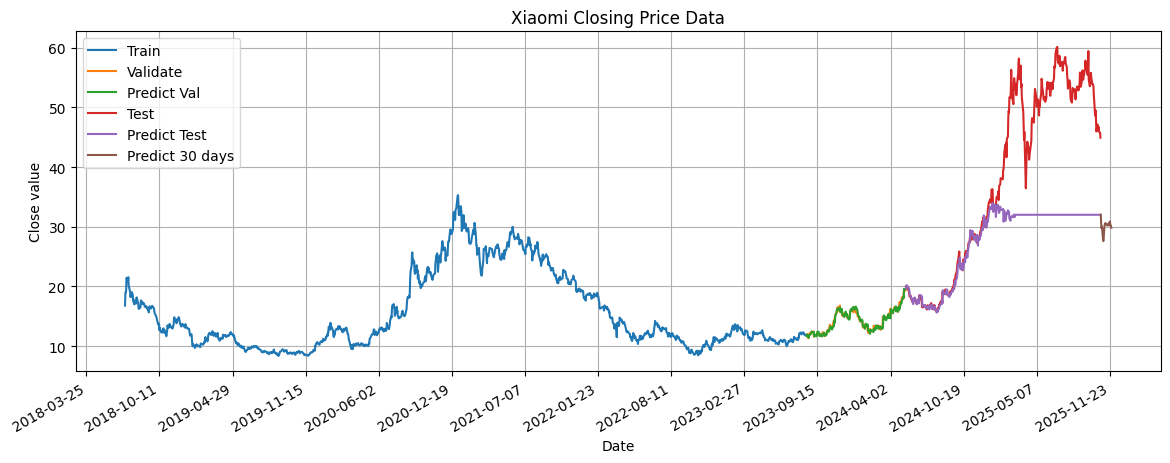

In [23]:
# Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate')
plt.plot(val_data_index, y_pred_val_inv, label='Predict Val')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')

plt.plot(predict_data_index, lst_output, label='Predict 30 days')

plt.grid()
plt.title(f"Xiaomi Closing Price Data")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() #  Rotate date labels for better readability
plt.legend()
#plt.savefig('../Image/GBT_712_Xiaomi.png')
plt.show()